<a id='top'></a>

# Méthodes de Monte-Carlo en Finance

# Projet 2 : Option barrière et diffusion tuée

Pierre ARTIGALA - Omar MANSOUR

## Consignes

Ce projet a pour but d'étudier le calcul du prix de certaines options barrières par méthode de Monte Carlo. Il se fonde sur l'article "Weak approximation of killed diffusion using Euler schemes" qui étudie deux méthodes de simulations. Votre rapport comportera au minimum :
- Une présentation du prix des options barrières dans le modèle de Black-Scholes pour obtenir des formules fermées.
- Une présentation des deux méthodes de l'article en commentant les démarches de preuves.
- Des simulatons testant ces méthodes (contre le formules fermées).

# Table of contents

## [Imports](#imports)
## [1. Prix des options barrières dans le modèle de Black-Scholes - Formules fermées](#part1)
## [2. Méthodes de Monte Carlo (article)](#part2)
## [3. Comparaison des différentes méthodes](#part3)

<a id='imports'></a>

# Imports [[^]](#top)

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

<a id='part1'></a>

# 1. Prix des options barrières dans le modèle de Black-Scholes - Formules fermées [[^]](#top)

In [55]:
def delta_plus(
    s: float,
    T: float,
    r: float,
    sigma: float
):
    """Compute delta_plus."""
    return (np.log(s) + (r + (sigma**2)/2) * T) / (sigma * (T**0.5))


def delta_minus(
    s: float,
    T: float,
    r: float,
    sigma: float
):
    """Compute delta_minus."""
    return (np.log(s) + (r - (sigma**2)/2) * T) / (sigma * (T**0.5))


def call(
    S: float, 
    K: float,
    T: float,
    r: float,
    sigma: float
):
    """Black-Scholes closed formula for a call option."""
    return S * norm.cdf(delta_plus(s=S/K, T=T, r=r, sigma=sigma)) - np.exp(-r*T) * K * norm.cdf(delta_minus(s=S/K, T=T, r=r, sigma=sigma))


def put(
    S: float, 
    K: float,
    T: float,
    r: float,
    sigma: float
):
    """Black-Scholes closed formula for a put option."""
    return np.exp(-r*T) * K * norm.cdf(-delta_minus(s=S/K, T=T, r=r, sigma=sigma)) - S * norm.cdf(-delta_plus(s=S/K, T=T, r=r, sigma=sigma))


## Knock-Out Barrier

Formules basées sur : https://personal.ntu.edu.sg/nprivault/MA5182/barrier-options.pdf

ÉCRIRE LES PRIX ET DÉCIDER DE SI ON DOIT INCLURE LA DÉMONSTRATION POUR AU MOINS UN PRIX.

In [94]:
def up_out_call(
    S: float, 
    K: float,
    B: float,
    T: float,
    r: float,
    sigma: float
):
    """Black-Scholes closed formula for an up-and-out call option."""
    # If the price is breaking the barrier already, the value is zero
    if S >= B:
        return 0
    # If the up-and-out barrier is lower than the strike, the price is zero (the payoff can only be zero)
    if B <= K:
        return 0
    else:
        return call(S=S, K=K, T=T, r=r, sigma=sigma) - S * norm.cdf(delta_plus(s=S / B, T=T, r=r, sigma=sigma)) - (
        B * (B / S)**(2*r/(sigma**2))) * (norm.cdf(delta_plus(s=B**2/(K*S), T=T, r=r, sigma=sigma)) - norm.cdf(delta_plus(s=B / S, T=T, r=r, sigma=sigma))) - np.exp(-r*T) * K * (
            - norm.cdf(delta_minus(s=S / B, T=T, r=r, sigma=sigma)) - 
        ((S / B) ** (1-2*r/(sigma**2))) * (norm.cdf(delta_minus(s=B**2/(K*S), T=T, r=r, sigma=sigma)) - norm.cdf(delta_minus(s=B / S, T=T, r=r, sigma=sigma)))
        )


def up_out_put(
    S: float, 
    K: float,
    B: float,
    T: float,
    r: float,
    sigma: float
):
    """Black-Scholes closed formula for an up-and-out put option."""
    # If the price is breaking the barrier already, the value is zero
    if S >= B:
        return 0
    if B <= K:
        return S * (norm.cdf(delta_plus(s=S / B, T=T, r=r, sigma=sigma)) - 1 - (B / S) ** (1+2*r/(sigma**2)) * (norm.cdf(delta_plus(s=B/S, T=T, r=r, sigma=sigma)) - 1)) - K * np.exp(-r*T) * (
        norm.cdf(delta_minus(s=S / B, T=T, r=r, sigma=sigma)) - 1 - (S / B) ** (1-2*r/(sigma**2)) * (norm.cdf(delta_minus(s=B/S, T=T, r=r, sigma=sigma)) - 1)
        )
    else:
        return S * (norm.cdf(delta_plus(s=S / K, T=T, r=r, sigma=sigma)) - 1 - (B / S) ** (1+2*r/(sigma**2)) * (norm.cdf(delta_plus(s=B**2/(K*S), T=T, r=r, sigma=sigma)) - 1)) - K * np.exp(-r*T) * (
        norm.cdf(delta_minus(s=S / K, T=T, r=r, sigma=sigma)) - 1 - (S / B) ** (1-2*r/(sigma**2)) * (norm.cdf(delta_minus(s=B**2/(K*S), T=T, r=r, sigma=sigma)) - 1)
        )


def down_out_call(
    S: float, 
    K: float,
    B: float,
    T: float,
    r: float,
    sigma: float
):
    """Black-Scholes closed formula for an down-and-out call option."""
    # If the price is breaking the barrier already, the value is zero
    if S <= B:
        return 0
    if B <= K:
        return call(S=S, K=K, T=T, r=r, sigma=sigma) - S * (B/S)**(2*r/sigma**2) * call(S=B/S, K=K/B, T=T, r=r, sigma=sigma)
    else:
        return S * norm.cdf(delta_plus(s=S/B, T=T, r=r, sigma=sigma
        )) - K * np.exp(-r*T) * norm.cdf(delta_minus(s=S/B, T=T, r=r, sigma=sigma
        )) - B * (B/S)**(2*r/(sigma**2)) * norm.cdf(delta_plus(s=B/S, T=T, r=r, sigma=sigma
        )) + K * np.exp(-r*T) * (S/B)**(1-2*r/(sigma**2)) * norm.cdf(delta_minus(s=B/S, T=T, r=r, sigma=sigma))


def down_out_put(
    S: float, 
    K: float,
    B: float,
    T: float,
    r: float,
    sigma: float
):
    """Black-Scholes closed formula for an down-and-out put option."""
    # If the price is breaking the barrier already, the value is zero
    if S <= B:
        return 0
    if B >= K:
        return 0
    else:
        return put(S=S, K=K, T=T, r=r, sigma=sigma) + S * norm.cdf(-delta_plus(s=S/B, T=T, r=r, sigma=sigma
        )) - B * (B/S)**(2*r/(sigma**2)) * (norm.cdf(delta_plus(s=B**2/(K*S), T=T, r=r, sigma=sigma)) - norm.cdf(delta_plus(s=B/S, T=T, r=r, sigma=sigma))
        ) - K * np.exp(-r*T) * norm.cdf(-delta_minus(s=S/B, T=T, r=r, sigma=sigma
        )) + K * np.exp(-r*T) * (S/B)**(1-2*r/(sigma**2)) * (norm.cdf(delta_minus(s=B**2/(K*S), T=T, r=r, sigma=sigma)) - norm.cdf(delta_minus(s=B/S, T=T, r=r, sigma=sigma))
        )

In [95]:
S = 80
K = 79
B = 70
T = 100 / 365
r = 0.05
sigma = 0.1

price = up_out_call(S=S, K=K, B=B, T=T, r=r, sigma=sigma)
price

0

## Knock-In Barrier

Formules basées sur https://www.asc.tuwien.ac.at/~juengel/simulations/fincalculator/doc/Barrier.pdf

Je suis un peu étonné parce que les formules comme c_ui = c - c_uo sont valables pour tout K, B (X, H dans le document) mais il garde la disjonction de cas H < B vs H >= B au lieu de simplifier...

In [96]:
def down_in_call(
    S: float, 
    K: float,
    B: float,
    T: float,
    r: float,
    sigma: float
):
    """
    Black-Scholes closed formula for an down-and-in call option.
    c_di = c - c_do
    """
    return call(S=S, K=K, T=T, r=r, sigma=sigma) - down_out_call(S=S, K=K, B=B, T=T, r=r, sigma=sigma)


def down_in_put(
    S: float, 
    K: float,
    B: float,
    T: float,
    r: float,
    sigma: float
):
    """
    Black-Scholes closed formula for an down-and-in put option.
    p_di = p - p_do
    """
    return put(S=S, K=K, T=T, r=r, sigma=sigma) - down_out_put(S=S, K=K, B=B, T=T, r=r, sigma=sigma)


def up_in_call(
    S: float, 
    K: float,
    B: float,
    T: float,
    r: float,
    sigma: float
):
    """
    Black-Scholes closed formula for an up-and-in call option.
    c_ui = c - c_uo
    """
    return call(S=S, K=K, T=T, r=r, sigma=sigma) - up_out_call(S=S, K=K, B=B, T=T, r=r, sigma=sigma)


def up_in_put(
    S: float, 
    K: float,
    B: float,
    T: float,
    r: float,
    sigma: float
):
    """
    Black-Scholes closed formula for an up-and-in call option.
    p_ui = p - p_uo
    """
    return put(S=S, K=K, T=T, r=r, sigma=sigma) - up_out_put(S=S, K=K, B=B, T=T, r=r, sigma=sigma)

In [97]:
S = 60
K = 65
B = 67
T = 100 / 365
r = 0.05
sigma = 0.1

price = up_in_call(S=S, K=K, B=B, T=T, r=r, sigma=sigma)
price

0.1278309479867974

# Plots

In [132]:
MAPPING_FUNCTIONS = {
    "call": {
        "up_in": up_in_call,
        "up_out": up_out_call,
        "down_in": down_in_call,
        "down_out": down_out_call,
    },
    "put": {
        "up_in": up_in_put,
        "up_out": up_out_put,
        "down_in": down_in_put,
        "down_out": down_out_put,
    }
}

def plot_price_surface(
    K: float,
    B: float,
    r: float,
    sigma: float,
    type_option: str,
    type_barrier: str
    ):
    """Plot the price surface for the barrier option as a function of T and S."""
    # Get the appropriate function to compute the price
    f = MAPPING_FUNCTIONS[type_option][type_barrier]
    # List of S
    l_S = np.linspace(50, 90, 30)
    # List of T
    l_T = np.linspace(100, 220, 30) / 365

    # Meshgrid for the surface
    S, T = np.meshgrid(l_S, l_T)

    # Compute the option price
    price = np.vectorize(f)(S=S, K=K, B=B, T=T, r=r, sigma=sigma)

    # Plot
    fig = plt.subplots()
    ax = plt.axes(projection='3d')
    ax.plot_surface(S, T, price, edgecolors='r', lw=0.6, alpha=0)
    ax.set_xlabel('S ($)')
    ax.set_ylabel('T (days)')
    ax.set_zlabel('Price ($)')
    str_title = type_barrier + " " + type_option + " price surface (K=" + str(K) + ", B=" + str(B) + ")"
    ax.set_title(str_title)
    # Change the X-ticks labels
    labels = ax.get_yticks().tolist()
    labels = [int(float(l) * 365) for l in labels]
    ax.set_yticklabels(labels)
    return price

/var/folders/j3/spc50n0x3zd65x0wd5w0fkxh0000gn/T/ipykernel_27052/3205042566.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


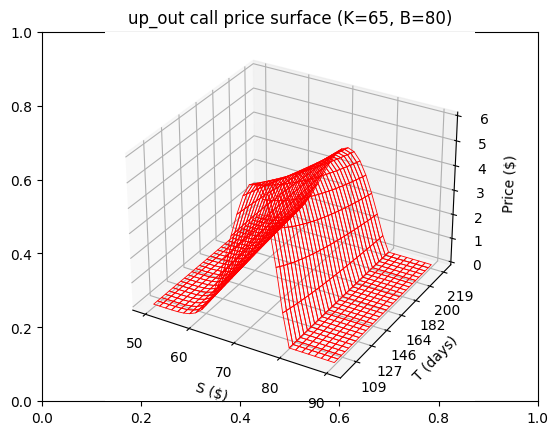

In [134]:
K = 65
B = 80
r = 0.03
sigma = 0.12
type_option = "call"
type_barrier = "up_out"

price = plot_price_surface(K=K, B=B, r=r, sigma=sigma, type_option=type_option, type_barrier=type_barrier)

In [140]:
def plot_price_vs_volatility(
    S: float,
    K: float,
    B: float,
    T: float,
    r: float,
    type_option: str,
    type_barrier: str
    ):
    """Plot the option price as a function of volatility"""
    # Get the appropriate function to compute the price
    f = MAPPING_FUNCTIONS[type_option][type_barrier]
    # List of sigma
    l_sigma = np.linspace(0.001, 1, 100)

    # Compute the option price
    price = np.vectorize(f)(S=S, K=K, B=B, T=T, r=r, sigma=l_sigma)

    high = S - K*np.exp(-r*T)
    low = S - B
    # Plot
    fig, ax = plt.subplots()
    ax.plot(l_sigma, price, c="r")
    ax.axhline(high, c="b")
    ax.axhline(low, c="purple")
    ax.grid()
    ax.set_xlabel('Volatility')
    ax.set_ylabel('Price ($)')
    str_title = type_barrier + " " + type_option + " price VS volatility (K=" + str(K) + ", B=" + str(B) + ")"
    ax.set_title(str_title)

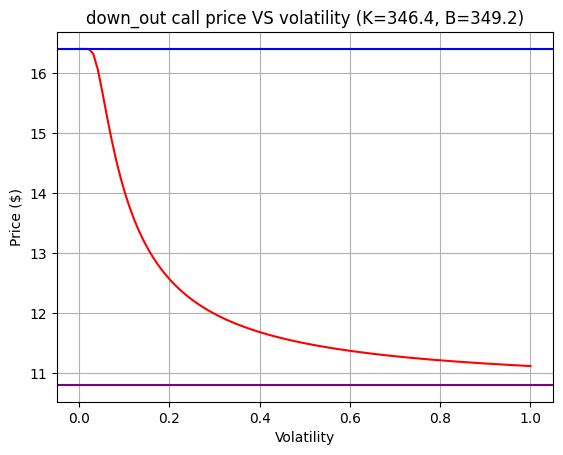

In [144]:
S = 360
K = 346.4
B = 349.2
r = 0.03
T = 99/365
type_option = "call"
type_barrier = "down_out"

plot_price_vs_volatility(S=S, K=K, B=B, r=r, T=T, type_option=type_option, type_barrier=type_barrier)

# Draft

TO DO:
- Plot price surfaces and compare to the article.
- Decide what should be included in the report and write the corresponding Latex.

DONE:
- Implementation of all the barrier options closed formulas in the Black-Scholes model.